#### Update for v1.1
- v1.0 was valid to work
- v1.1 added doPrediction for predict whole CT scan as in test setting. 

# Configuration

In [1]:
MODEL_TO_LOAD = ''
FN_LOSS = 0
TRAINING_NAME = '3D_Unet_Res_lv5_All128_LyticOnly_Copy3'
TB_PREFIX = 'bonemeta_fn_{}'.format(FN_LOSS) + '_{}'.format(TRAINING_NAME)

PATCH_SIZE = 128

# BATCH_SIZE = 120
BATCH_SIZE = 4
EPOCHS = 100

BASE_DIR = '/workspace/BoneMeta_all_128'
IMG_FOLDER_NAME = 'images'
LABEL_FOLDER_NAME = 'labels_lytic'
BONE_SEG_FOLDER_NAME = 'bone_seg'

In [2]:
import os
import sys
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import random

# Set dataset

In [3]:
IMG_DIR = os.path.join(BASE_DIR, IMG_FOLDER_NAME)
LABEL_DIR = os.path.join(BASE_DIR, LABEL_FOLDER_NAME)

IMG_FILES = os.listdir(IMG_DIR)
LABEL_FILES = os.listdir(LABEL_DIR)

def get_img_path(file): 
    return os.path.join(IMG_DIR, file)

def get_label_path(file):
    return os.path.join(LABEL_DIR, file)

def case_to_file(case):
    return case+'.npy'

def file_to_case(file_name):
    return file_name.split('.')[0]

set(IMG_FILES).issubset(LABEL_FILES)

True

In [4]:
print(IMG_DIR, len(IMG_FILES))
print(LABEL_DIR, len(LABEL_FILES))

/workspace/BoneMeta_all_128/images 310
/workspace/BoneMeta_all_128/labels_lytic 310


In [5]:
len(set(IMG_FILES)-set(LABEL_FILES))

0

In [6]:
# z축 작은 녀석들만 남기기 
SMALL_Z_CASES = ['000251_20190703_chest', '000356_20191024_chest', '000350_20190927_chest', '000397_20200214_chest', 'BH005_20170701_abdomen', 'BH041_20190201_C-T-L Spine (3D)', 'BH005_20170701_chest', '000355_20190901_abdomen', '000022_20180830_chest', '000244_20190501_abdomen', '000332_20191025_chest', '000019_20181018_chest', 'BH011_20190301_Spine^00_C_Spine_Pre_OP (Adult)', '000019_20190613_chest', 'BH017_20191201_abdomen', '000273_20190531_chest', '000404_20200305_chest', '000286_20190701_abdomen', 'SN015_20190901_chest', '000391_20200216_Thoracic Aorta CT Angio+3D (contrast)', '000262_20190501_abdomen', 'SN013_20190401_chest', '000285_20190807_chest', '000362_20191201_abdomen', '000322_20190913_chest', 'BH057_20191227_chest', '000400_20200210_chest', 'BH064_20200605_abdomen', 'BH034_20190901_chest', '000298_20190726_chest', '000311_20190902_chest', '000396_20200201_abdomen', '000223_20190319_chest', 'BH032_20180701_abdomen', '000291_20190701_abdomen', 'BH045_20181001_abdomen', '000296_20190726_chest', 'BH066_20190525_chest', 'BH010_20161101_chest', '000251_20190701_abdomen', 'SN007_20190701_chest', '000193_20190114_chest', '000262_20190529_chest', '000251_20190429_chest', 'BH060_20200413_chest', '000234_20190419_chest', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2)', 'BH070_20160823_chest', '000316_20190627_chest', '000356_20190901_abdomen', '000383_20200121_chest', 'BH052_20190901_chest', '000450_20200512_chest', '000276_20190604_chest', '000364_20191217_chest', 'BH025_20191101_abdomen', 'BH035_20191101_GU Kidney & bladder CT (3D)', 'BH018_20190801_chest', '000269_20190601_abdomen', 'BH008_20190701_chest', '000332_20191001_abdomen', 'BH043_20191001_abdomen', '000260_20190522_chest', 'BH007_20190801_chest', 'BH067_20191017_chest', '000279_20190614_chest', 'SN004_20190901_chest', 'BH042_20180801_C-T-L Spine (3D)', 'BH099_20200806_abdomen', 'BH055_20200328_chest', 'BH001_20190401_chest', '000162_20180131_chest', 'BH054_20191122_abdomen', '000450_20200501_abdomen', 'BH030_20160101_T-L spine (3D)', '000372_20200107_chest', 'BH069_20200505_chest', 'BH012_20180401_abdomen', 'BH058_20180918_chest', '000404_20200201_abdomen', 'BH048_20190501_chest', '000348_20191201_CT Liver (contrast)', 'BH002_20190701_chest', '000376_20200101_abdomen', '000309_20190801_abdomen', 'SN017_20190701_chest', 'BH029_20200101_chest', 'BH059_20201013_abdomen', '000310_20190801_abdomen', '000272_20190614_chest', 'BH027_20191001_L-spine CT (3D)', 'BH064_20200605_chest', '000350_20191001_abdomen', '000232_20190423_chest', 'BH001_20190501_abdomen', 'BH039_20190601_chest', 'SN008_20190901_chest', '000270_20190608_chest', 'BH091_20200104_chest', '000269_20190604_chest', '000331_20190916_chest', '000325_20190919_chest', '000363_20191222_chest', '000260_20190501_CT Liver (contrast)', '000330_20190926_chest', 'BH072_20200219_abdomen', '000324_20190910_chest', 'BH009_20180301_chest', 'BH028_20190801_chest', 'SN029_20200301_chest', 'BH110_20200616_chest', '000401_20200201_T-Spine+3D CT (noncontrast)', 'SN031_20160501_chest', 'SN005_20191101_chest', '000452_20200513_chest', '000021_20181227_chest', '000236_20190401_abdomen', 'SN002_20190801_chest', '000382_20200129_chest', '000301_20190801_Pulmonary artery CT Angio+3D (contrast)', 'BH015_20190101_chest', 'BH043_20191001_chest', 'BH063_20200519_chest', '000363_20191201_abdomen', '000354_20191001_abdomen', 'BH047_20180901_abdomen', '000079_20180911_Pulmonary artery CT Angio+3D (contrast)', 'BH016_20151001_chest', 'BH061_20190315_abdomen', 'BH014_20181201_chest', '000362_20191214_chest', '000354_20191022_chest', 'SN051_20170401_chest', 'SN036_20190601_chest', 'BH017_20191201_chest', '000282_20190701_abdomen', 'BH023_20191101_chest', '000085_20180829_chest', 'SN019_20190801_chest', '000212_20190324_chest', '000302_20190726_chest', 'BH009_20180301_abdomen', 'BH008_20190701_abdomen', '000301_20190801_abdomen', 'BH015_20190101_abdomen', 'SN028_20160801_chest', '000344_20191125_chest', 'BH014_20181201_abdomen', '000214_20190325_chest', '000386_20200204_chest', '000372_20200101_abdomen', 'BH091_20200104_GU Kidney & bladder CT (3D)', 'SN025_20200401_chest', '000400_20200201_CT Biliary (contrast)', '000255_20190418_chest', 'BH081_20190322_abdomen', '000315_20190820_chest', '000288_20190701_abdomen', '000272_20190601_abdomen', '000322_20190901_abdomen', '000331_20190901_abdomen', 'SN055_20170301_chest', 'BH052_20190901_abdomen', '000310_20190812_chest', '000069_20180319_chest', 'BH024_20190501_abdomen', 'BH021_20181001_abdomen', '000009_20180417_chest', 'BH037_20171101_abdomen', '000002_20180829_chest', '000234_20190401_abdomen', '000262_20190318_chest', 'SN016_20190901_chest', '000232_20190401_abdomen', 'SN056_20170601_Thorax^01_Lung_Cancer_3D (Adult)', '000300_20190801_abdomen', 'BH006_20170801_chest', '000278_20190620_chest', 'BH036_20180301_GU Kidney & bladder CT (3D)', 'BH019_20191101_chest', 'BH004_20191101_chest', '000382_20200101_abdomen', '000242_20190409_chest', 'BH061_20190315_chest', '000080_20180911_chest', '000355_20191023_chest', '000364_20191201_abdomen', 'BH018_20190801_abdomen', '000291_20190718_chest', '000279_20190601_abdomen', '000308_20190826_chest', '000305_20190801_abdomen', 'BH010_20161101_abdomen', 'BH007_20190801_abdomen', 'BH021_20181001_chest', '000396_20200218_chest', '000091_20180504_chest', 'SN042_20170901_chest', '000314_20190827_chest', 'BH031_20160301_CT Angio + 3D Pulmonary artery (Embolism)', 'BH023_20191101_abdomen', '000301_20190827_chest', 'BH062_20201104_chest', 'BH020_20191201_chest', 'BH059_20201019_chest', '000246_20190629_chest', 'BH026_20190601_abdomen', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism)', 'BH034_20190901_abdomen', 'BH099_20200806_chest', 'BH051_20190301_GU Kidney & bladder CT (3D)', '000368_20200101_abdomen', 'BH057_20191227_abdomen', 'BH112_20190201_chest', 'BH024_20190501_chest', 'BH013_20191001_chest', '000309_20190823_chest', '000011_20181207_chest', 'BH020_20191201_abdomen', 'BH027_20191001_chest', '000316_20190715_Spine^L_SPINE (Adult)', '000012_20181214_chest', 'BH032_20180701_chest', 'BH037_20171101_chest', '000285_20190801_abdomen', 'BH038_20160901_CT angio + 3D C-spine(vertebral artery, C1-2)', 'BH072_20200219_chest', 'SN054_20170201_chest', '000048_20190501_abdomen', '000304_20190124_chest', 'BH045_20181001_chest', '000352_20191001_abdomen', 'BH016_20151001_abdomen', 'BH022_20190101_chest', 'BH047_20180901_chest', '000314_20190901_abdomen', 'BH065_20201013_chest', 'BH056_20200721_chest', '000281_20190701_chest', '000025_20180808_chest', '000352_20191017_chest', 'BH012_20180401_chest', '000224_20190228_chest', '000308_20190801_abdomen', '000376_20200114_chest']
SMALL_Z_FILES = [case_to_file(case) for case in SMALL_Z_CASES]
IMG_FILES = list(set(IMG_FILES).intersection(SMALL_Z_FILES))
len(IMG_FILES)

245

In [7]:
TRAIN_FILES = ['000019_20181018_chest.npy', '000019_20190601_abdomen.npy', '000019_20190613_chest.npy', '000021_20181227_chest.npy', '000022_20180830_chest.npy', '000025_20180808_abdomen.npy', '000025_20180808_chest.npy', '000080_20180911_chest.npy', '000085_20180829_chest.npy', '000091_20180504_chest.npy', '000162_20180131_chest.npy', '000193_20190114_chest.npy', '000214_20190325_chest.npy', '000223_20190319_chest.npy', '000224_20190228_chest.npy', '000234_20190401_abdomen.npy', '000234_20190419_chest.npy', '000236_20190401_abdomen.npy', '000242_20190409_chest.npy', '000244_20190501_abdomen.npy', '000246_20190629_chest.npy', '000251_20190429_abdomen.npy', '000251_20190429_chest.npy', '000251_20190701_abdomen.npy', '000251_20190703_chest.npy', '000255_20190418_chest.npy', '000262_20190318_chest.npy', '000262_20190319_abdomen.npy', '000262_20190501_abdomen.npy', '000262_20190529_chest.npy', '000269_20181016_abdomen.npy', '000269_20181214_abdomen.npy', '000269_20190325_abdomen.npy', '000269_20190601_abdomen.npy', '000269_20190604_chest.npy', '000270_20190601_abdomen.npy', '000270_20190608_chest.npy', '000276_20190604_chest.npy', '000279_20190601_abdomen.npy', '000279_20190614_chest.npy', '000280_20190625_CT Liver (contrast).npy', '000281_20190701_chest.npy', '000282_20190410_abdomen.npy', '000282_20190701_abdomen.npy', '000286_20190701_abdomen.npy', '000286_20190710_chest.npy', '000288_20190701_abdomen.npy', '000291_20190701_abdomen.npy', '000291_20190718_chest.npy', '000296_20190726_chest.npy', '000301_20190801_abdomen.npy', '000301_20190801_Pulmonary artery CT Angio+3D (contrast).npy', '000301_20190827_chest.npy', '000302_20190726_chest.npy', '000304_20190124_chest.npy', '000304_20190124_CT Liver (contrast).npy', '000308_20190801_abdomen.npy', '000308_20190826_chest.npy', '000309_20190801_abdomen.npy', '000309_20190823_chest.npy', '000311_20190902_chest.npy', '000314_20190827_chest.npy', '000314_20190901_abdomen.npy', '000315_20190820_chest.npy', '000315_20190901_abdomen.npy', '000322_20190901_abdomen.npy', '000322_20190913_chest.npy', '000324_20190910_chest.npy', '000325_20190919_chest.npy', '000330_20190926_chest.npy', '000331_20190901_abdomen.npy', '000331_20190916_chest.npy', '000332_20191001_abdomen.npy', '000332_20191025_chest.npy', '000344_20191125_chest.npy', '000352_20191001_abdomen.npy', '000352_20191017_chest.npy', '000354_20191001_abdomen.npy', '000354_20191022_chest.npy', '000355_20190901_abdomen.npy', '000355_20191023_chest.npy', '000356_20190901_abdomen.npy', '000356_20191024_chest.npy', '000362_20191201_abdomen.npy', '000362_20191214_chest.npy', '000363_20191201_abdomen.npy', '000363_20191222_chest.npy', '000364_20191201_abdomen.npy', '000364_20191217_chest.npy', '000368_20200101_abdomen.npy', '000372_20200101_abdomen.npy', '000372_20200107_chest.npy', '000376_20200101_abdomen.npy', '000376_20200114_chest.npy', '000382_20200101_abdomen.npy', '000382_20200129_chest.npy', '000386_20200204_chest.npy', '000396_20200201_abdomen.npy', '000396_20200218_chest.npy', '000404_20200201_abdomen.npy', '000404_20200305_chest.npy', 'BH004_20191101_chest.npy', 'BH008_20190701_abdomen.npy', 'BH008_20190701_chest.npy', 'BH009_20180301_abdomen.npy', 'BH009_20180301_chest.npy', 'BH010_20161101_abdomen.npy', 'BH010_20161101_chest.npy', 'BH011_20190301_Spine^00_C_Spine_Pre_OP (Adult).npy', 'BH012_20180401_abdomen.npy', 'BH012_20180401_chest.npy', 'BH013_20191001_chest.npy', 'BH014_20181201_abdomen.npy', 'BH014_20181201_chest.npy', 'BH015_20190101_abdomen.npy', 'BH015_20190101_chest.npy', 'BH016_20151001_abdomen.npy', 'BH016_20151001_chest.npy', 'BH017_20191201_abdomen.npy', 'BH017_20191201_chest.npy', 'BH018_20190801_abdomen.npy', 'BH018_20190801_chest.npy', 'BH019_20191101_chest.npy', 'BH020_20191201_abdomen.npy', 'BH020_20191201_chest.npy', 'BH021_20181001_abdomen.npy', 'BH021_20181001_chest.npy', 'BH022_20190101_chest.npy', 'BH023_20191101_abdomen.npy', 'BH023_20191101_chest.npy', 'BH024_20190501_abdomen.npy', 'BH024_20190501_chest.npy', 'BH025_20191101_abdomen.npy', 'BH026_20190601_abdomen.npy', 'BH028_20190801_chest.npy', 'BH029_20200101_chest.npy', 'BH030_20160101_T-L spine (3D).npy', 'BH031_20160301_CT Angio + 3D Pulmonary artery (Embolism).npy', 'BH032_20180701_abdomen.npy', 'BH032_20180701_chest.npy', 'BH034_20190901_abdomen.npy', 'BH034_20190901_chest.npy', 'BH035_20191101_GU Kidney & bladder CT (3D).npy', 'BH036_20180301_GU Kidney & bladder CT (3D).npy', 'BH037_20171101_abdomen.npy', 'BH037_20171101_chest.npy', 'BH038_20160901_CT angio + 3D C-spine(vertebral artery, C1-2).npy', 'BH042_20180801_C-T-L Spine (3D).npy', 'BH043_20191001_abdomen.npy', 'BH043_20191001_chest.npy', 'BH045_20181001_abdomen.npy', 'BH045_20181001_chest.npy', 'BH047_20180901_abdomen.npy', 'BH048_20190501_chest.npy', 'BH051_20190301_GU Kidney & bladder CT (3D).npy', 'BH052_20190901_abdomen.npy', 'BH052_20190901_chest.npy', 'BH054_20191122_abdomen.npy', 'BH055_20200328_chest.npy', 'BH056_20200721_chest.npy', 'BH057_20191227_abdomen.npy', 'BH057_20191227_chest.npy', 'BH058_20180918_chest.npy', 'BH059_20201013_abdomen.npy', 'BH059_20201019_chest.npy', 'BH064_20200605_abdomen.npy', 'BH064_20200605_chest.npy', 'BH066_20190525_chest.npy', 'BH067_20191017_chest.npy', 'BH069_20200505_chest.npy', 'BH081_20190322_abdomen.npy', 'BH112_20190201_chest.npy', 'SN001_20190901_abdomen.npy', 'SN002_20190801_abdomen.npy', 'SN002_20190801_chest.npy', 'SN005_20191001_abdomen.npy', 'SN005_20191101_chest.npy', 'SN007_20190701_chest.npy', 'SN007_20190801_abdomen.npy', 'SN008_20190901_chest.npy', 'SN009_20190801_abdomen.npy', 'SN009_20190801_chest.npy', 'SN010_20190801_CT Liver+Pelvis(contrast).npy', 'SN011_20180401_abdomen.npy', 'SN011_20180401_chest.npy', 'SN012_20150801_abdomen.npy', 'SN013_20190401_abdomen.npy', 'SN013_20190401_chest.npy', 'SN014_20190901_abdomen.npy', 'SN014_20190901_chest.npy', 'SN015_20190901_abdomen.npy', 'SN015_20190901_chest.npy', 'SN016_20190901_abdomen.npy', 'SN016_20190901_chest.npy', 'SN018_20190801_abdomen.npy', 'SN018_20190801_chest.npy', 'SN020_20190801_abdomen.npy', 'SN020_20190801_chest.npy', 'SN025_20200401_abdomen.npy', 'SN025_20200401_chest.npy', 'SN028_20160801_abdomen.npy', 'SN028_20160801_chest.npy', 'SN032_20190401_T spine CT pre contr.npy', 'SN032_20190501_abdomen.npy', 'SN036_20190601_chest.npy', 'SN039_20181001_abdomen.npy', 'SN039_20181001_chest.npy', 'SN040_20170201_abdomen.npy', 'SN040_20170201_CT Neck (contrast).npy', 'SN042_20170901_abdomen.npy', 'SN042_20170901_chest.npy', 'SN043_20170701_chest.npy', 'SN044_20160601_CT Liver+Pelvis(contrast).npy', 'SN045_20170201_abdomen.npy', 'SN045_20170201_chest.npy', 'SN051_20170401_abdomen.npy', 'SN051_20170401_chest.npy', 'SN054_20170201_chest.npy', 'SN055_20170301_abdomen.npy', 'SN055_20170301_chest.npy', '000383_20200121_chest.npy', '000450_20200501_abdomen.npy', '000450_20200512_chest.npy', '000452_20200513_chest.npy', 'BH047_20180901_chest.npy']
VAL_FILES = ['000316_20190627_chest.npy', '000316_20190715_Spine^L_SPINE (Adult).npy', 'SN034_20200101_abdomen.npy', 'SN034_20200101_chest.npy', 'SN059_20170501_chest.npy', 'BH027_20191001_L-spine CT (3D).npy', '000397_20200214_chest.npy', 'BH027_20191001_chest.npy', 'BH039_20190601_chest.npy', 'BH041_20190201_C-T-L Spine (3D).npy', 'BH060_20200413_chest.npy', 'BH062_20201104_chest.npy', 'SN035_20180101_chest.npy', 'SN048_20170801_chest.npy', '000232_20190401_abdomen.npy', '000232_20190423_chest.npy', '000285_20190801_abdomen.npy', '000285_20190807_chest.npy', '000348_20191201_CT Liver (contrast).npy', '000401_20200201_T-Spine+3D CT (noncontrast).npy', 'BH006_20170801_chest.npy', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism).npy', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2).npy', 'BH065_20201013_chest.npy', 'BH099_20200806_abdomen.npy', 'BH099_20200806_chest.npy', 'BH110_20200616_chest.npy', 'SN004_20190801_abdomen.npy', 'SN004_20190901_chest.npy', 'SN017_20190701_chest.npy', 'SN017_20190801_abdomen.npy', 'SN029_20200301_abdomen.npy', 'SN029_20200301_chest.npy', 'SN030_20191101_abdomen.npy', 'SN049_20170901_abdomen.npy', 'SN049_20170901_chest.npy', 'SN050_20170401_chest.npy', 'SN056_20170601_Thorax^01_Lung_Cancer_3D (Adult).npy']
TEST_FILES = ['000009_20180417_chest.npy', '000079_20180911_Pulmonary artery CT Angio+3D (contrast).npy', '000212_20190324_chest.npy', 'BH001_20190501_abdomen.npy', '000048_20190501_abdomen.npy', '000069_20180319_chest.npy', '000278_20190620_chest.npy', 'SN046_20170601_abdomen.npy', 'BH005_20170701_chest.npy', '000002_20180829_chest.npy', '000005_20181202_abdomen.npy', '000010_20181214_abdomen.npy', '000011_20181207_abdomen.npy', '000011_20181207_chest.npy', '000012_20181212_abdomen.npy', '000012_20181214_chest.npy', '000260_20190501_CT Liver (contrast).npy', '000260_20190522_chest.npy', '000272_20190601_abdomen.npy', '000272_20190614_chest.npy', '000273_20190531_chest.npy', '000298_20190726_chest.npy', '000300_20190801_abdomen.npy', '000305_20190801_abdomen.npy', '000310_20190801_abdomen.npy', '000310_20190812_chest.npy', '000317_20190720_CT Liver (contrast).npy', '000350_20190927_chest.npy', '000350_20191001_abdomen.npy', '000391_20200216_Thoracic Aorta CT Angio+3D (contrast).npy', '000400_20200201_CT Biliary (contrast).npy', '000400_20200210_chest.npy', 'BH001_20190401_chest.npy', 'BH002_20190701_chest.npy', 'BH005_20170701_abdomen.npy', 'BH007_20190801_abdomen.npy', 'BH007_20190801_chest.npy', 'BH061_20190315_abdomen.npy', 'BH061_20190315_chest.npy', 'BH063_20200519_chest.npy', 'BH070_20160823_chest.npy', 'BH072_20200219_abdomen.npy', 'BH072_20200219_chest.npy', 'BH091_20200104_chest.npy', 'BH091_20200104_GU Kidney & bladder CT (3D).npy', 'SN019_20190801_abdomen.npy', 'SN019_20190801_chest.npy', 'SN031_20160501_abdomen.npy', 'SN031_20160501_chest.npy']

# EXCEPTIONS = ['BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism).npy', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2).npy'] # 모델에서 data info 만들때 가끔 오류남.
EXCEPTIONS = []

TRAIN_FILES = list(set(TRAIN_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))
VAL_FILES = list(set(VAL_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))
TEST_FILES = list(set(TEST_FILES).intersection(set(IMG_FILES)) - set(EXCEPTIONS))

# TRAIN_FILES = TRAIN_FILES[:50]
# VAL_FILES = VAL_FILES[:15]

In [8]:
TRAIN_FILES = ['000376_20200101_abdomen.npy', '000400_20200210_chest.npy', 'BH018_20190801_abdomen.npy', 'BH062_20201104_chest.npy', '000262_20190501_abdomen.npy', 'BH007_20190801_abdomen.npy', 'BH072_20200219_chest.npy', '000251_20190701_abdomen.npy', '000368_20200101_abdomen.npy', 'BH007_20190801_chest.npy', '000224_20190228_chest.npy', 'BH066_20190525_chest.npy', 'SN054_20170201_chest.npy', '000246_20190629_chest.npy', 'SN031_20160501_chest.npy', 'SN051_20170401_chest.npy', '000272_20190614_chest.npy', '000396_20200218_chest.npy', '000305_20190801_abdomen.npy', '000450_20200501_abdomen.npy', 'BH018_20190801_chest.npy', '000404_20200305_chest.npy', 'BH020_20191201_chest.npy', 'BH008_20190701_chest.npy', 'BH021_20181001_abdomen.npy', '000352_20191017_chest.npy', 'SN036_20190601_chest.npy', 'BH045_20181001_chest.npy', '000348_20191201_CT Liver (contrast).npy', '000262_20190318_chest.npy', '000350_20190927_chest.npy', 'BH025_20191101_abdomen.npy', '000021_20181227_chest.npy', 'BH055_20200328_chest.npy', '000372_20200107_chest.npy', '000270_20190608_chest.npy', 'BH002_20190701_chest.npy', '000386_20200204_chest.npy', 'BH005_20170701_abdomen.npy', 'BH036_20180301_GU Kidney & bladder CT (3D).npy', '000331_20190916_chest.npy', 'BH013_20191001_chest.npy', '000009_20180417_chest.npy', '000291_20190718_chest.npy', '000316_20190715_Spine^L_SPINE (Adult).npy', 'BH027_20191001_chest.npy', '000302_20190726_chest.npy', '000304_20190124_chest.npy', 'BH008_20190701_abdomen.npy', '000272_20190601_abdomen.npy', 'BH043_20191001_chest.npy', 'BH043_20191001_abdomen.npy', 'BH061_20190315_chest.npy', '000396_20200201_abdomen.npy', '000019_20181018_chest.npy', '000316_20190627_chest.npy', '000311_20190902_chest.npy', '000332_20191001_abdomen.npy', 'BH037_20171101_abdomen.npy', 'BH024_20190501_abdomen.npy', '000356_20191024_chest.npy', '000331_20190901_abdomen.npy', '000091_20180504_chest.npy', '000286_20190701_abdomen.npy', 'SN055_20170301_chest.npy', 'SN005_20191101_chest.npy', 'BH070_20160823_chest.npy', '000330_20190926_chest.npy', 'BH061_20190315_abdomen.npy', 'BH024_20190501_chest.npy', 'BH032_20180701_abdomen.npy', 'SN056_20170601_Thorax^01_Lung_Cancer_3D (Adult).npy', '000309_20190801_abdomen.npy', 'BH005_20170701_chest.npy', '000285_20190807_chest.npy', '000363_20191222_chest.npy', '000080_20180911_chest.npy', '000291_20190701_abdomen.npy', 'SN007_20190701_chest.npy', '000332_20191025_chest.npy', 'BH064_20200605_chest.npy', 'BH026_20190601_abdomen.npy', 'SN015_20190901_chest.npy', '000079_20180911_Pulmonary artery CT Angio+3D (contrast).npy', '000285_20190801_abdomen.npy', 'BH023_20191101_chest.npy', '000011_20181207_chest.npy', '000242_20190409_chest.npy', 'BH004_20191101_chest.npy', '000269_20190604_chest.npy', 'SN017_20190701_chest.npy', 'BH063_20200519_chest.npy', 'BH064_20200605_abdomen.npy', 'BH016_20151001_chest.npy', 'BH051_20190301_GU Kidney & bladder CT (3D).npy', '000324_20190910_chest.npy', 'BH060_20200413_chest.npy', '000300_20190801_abdomen.npy', 'BH019_20191101_chest.npy', '000048_20190501_abdomen.npy', '000315_20190820_chest.npy', '000352_20191001_abdomen.npy', '000282_20190701_abdomen.npy', '000310_20190812_chest.npy', '000193_20190114_chest.npy', '000362_20191214_chest.npy', 'BH037_20171101_chest.npy', '000279_20190614_chest.npy', '000162_20180131_chest.npy', '000279_20190601_abdomen.npy', 'BH091_20200104_GU Kidney & bladder CT (3D).npy', '000262_20190529_chest.npy', '000450_20200512_chest.npy', '000251_20190429_chest.npy', 'BH072_20200219_abdomen.npy', '000022_20180830_chest.npy', 'BH006_20170801_chest.npy', 'BH021_20181001_chest.npy', '000296_20190726_chest.npy', '000309_20190823_chest.npy', 'BH039_20190601_chest.npy', 'BH023_20191101_abdomen.npy', 'BH010_20161101_abdomen.npy', '000012_20181214_chest.npy', 'BH065_20201013_chest.npy', 'BH045_20181001_abdomen.npy', 'BH054_20191122_abdomen.npy', '000382_20200129_chest.npy', '000310_20190801_abdomen.npy', '000019_20190613_chest.npy', 'BH056_20200721_chest.npy', '000382_20200101_abdomen.npy', 'BH020_20191201_abdomen.npy', 'BH031_20160301_CT Angio + 3D Pulmonary artery (Embolism).npy', '000269_20190601_abdomen.npy', '000404_20200201_abdomen.npy', 'SN013_20190401_chest.npy', '000344_20191125_chest.npy', 'BH110_20200616_chest.npy', '000356_20190901_abdomen.npy', 'BH016_20151001_abdomen.npy', 'BH091_20200104_chest.npy', '000251_20190703_chest.npy', '000363_20191201_abdomen.npy', '000376_20200114_chest.npy', '000350_20191001_abdomen.npy', '000212_20190324_chest.npy', '000278_20190620_chest.npy', '000362_20191201_abdomen.npy', '000372_20200101_abdomen.npy', 'BH032_20180701_chest.npy', 'BH010_20161101_chest.npy', 'BH035_20191101_GU Kidney & bladder CT (3D).npy', '000400_20200201_CT Biliary (contrast).npy', '000301_20190801_Pulmonary artery CT Angio+3D (contrast).npy', '000301_20190801_abdomen.npy', '000325_20190919_chest.npy', '000301_20190827_chest.npy', 'BH040_20200101_CT Angio + 3D Pulmonary artery (Embolism) (2).npy', '000273_20190531_chest.npy', 'SN029_20200301_chest.npy', 'BH069_20200505_chest.npy', 'SN002_20190801_chest.npy', '000391_20200216_Thoracic Aorta CT Angio+3D (contrast).npy']

VAL_FILES = ['000364_20191201_abdomen.npy', '000364_20191217_chest.npy', 'BH012_20180401_abdomen.npy', '000085_20180829_chest.npy', '000397_20200214_chest.npy', '000223_20190319_chest.npy', '000322_20190901_abdomen.npy', 'BH081_20190322_abdomen.npy', 'BH048_20190501_chest.npy', 'BH015_20190101_abdomen.npy', 'BH029_20200101_chest.npy', 'BH099_20200806_chest.npy', 'BH012_20180401_chest.npy', 'SN008_20190901_chest.npy', 'SN019_20190801_chest.npy', 'SN025_20200401_chest.npy', 'SN004_20190901_chest.npy', '000308_20190801_abdomen.npy', 'BH015_20190101_chest.npy', 'BH059_20201019_chest.npy', '000452_20200513_chest.npy', '000232_20190423_chest.npy', 'BH034_20190901_chest.npy', 'BH034_20190901_abdomen.npy', 'BH099_20200806_abdomen.npy', 'BH028_20190801_chest.npy', '000308_20190826_chest.npy', '000002_20180829_chest.npy', '000232_20190401_abdomen.npy', 'SN042_20170901_chest.npy', 'BH059_20201013_abdomen.npy', '000025_20180808_chest.npy', 'BH067_20191017_chest.npy', '000069_20180319_chest.npy', '000322_20190913_chest.npy']

TEST_FILES = ['000355_20190901_abdomen.npy', '000234_20190401_abdomen.npy', '000255_20190418_chest.npy', '000281_20190701_chest.npy', 'SN016_20190901_chest.npy', '000236_20190401_abdomen.npy', '000288_20190701_abdomen.npy', 'BH057_20191227_chest.npy', '000234_20190419_chest.npy', 'BH001_20190501_abdomen.npy', 'BH014_20181201_chest.npy', '000314_20190827_chest.npy', '000276_20190604_chest.npy', '000314_20190901_abdomen.npy', '000298_20190726_chest.npy', 'BH047_20180901_abdomen.npy', 'BH017_20191201_abdomen.npy', 'BH001_20190401_chest.npy', 'BH022_20190101_chest.npy', '000383_20200121_chest.npy', 'SN028_20160801_chest.npy', '000260_20190522_chest.npy', 'BH112_20190201_chest.npy', 'BH009_20180301_abdomen.npy', 'BH047_20180901_chest.npy', 'BH057_20191227_abdomen.npy', '000354_20191001_abdomen.npy', 'BH052_20190901_abdomen.npy', '000355_20191023_chest.npy', 'BH058_20180918_chest.npy', 'BH017_20191201_chest.npy', 'BH009_20180301_chest.npy', '000354_20191022_chest.npy', 'BH052_20190901_chest.npy', '000244_20190501_abdomen.npy', '000260_20190501_CT Liver (contrast).npy', 'BH014_20181201_abdomen.npy', '000214_20190325_chest.npy']

In [9]:
print(f'''
train: {len(TRAIN_FILES)}
val: {len(VAL_FILES)}
test: {len(TEST_FILES)}
total: {len(TRAIN_FILES + VAL_FILES + TEST_FILES)}
''')


train: 164
val: 35
test: 38
total: 237



In [10]:
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

### Select Lytic Lesions Only

In [11]:
data_info = pd.read_csv(os.path.join(BASE_DIR, 'data_info.csv'))
data_info.head()

,Case,Lesion Type,Lesion Location,I/V,File Name,Lesion Size,Background Size,Original Shape[x],Original Shape[y],Original Shape[z],...,Spine Original Center[z],x_spacing,y_spacing,z_spacing,Spine 1mm Resized Center[x],Spine 1mm Resized Center[y],Spine 1mm Resized Center[z],Spine 1mm Resized Shape[x],Spine 1mm Resized Shape[y],Spine 1mm Resized Shape[z]
0,000002_20180829_chest,M,T10,I,lesionAnnot3D-004,3449,104854151,512,512,400,...,266,0.736328,0.736328,1.0,40.734375,142.75,266,188.5,188.5,400
1,000005_20181202_abdomen,L,L5,V,lesionAnnot3D-001,34062,37976818,512,512,145,...,92,0.630859,0.630859,3.0,61.828125,107.25,276,161.5,161.5,435
2,000009_20180417_chest,S,C7-1,V,lesionAnnot3D-001,2299,89126661,512,512,340,...,8,0.738281,0.738281,1.0,46.343750,132.50,8,189.0,189.0,340
3,000009_20180417_chest,S,C7-2,I,lesionAnnot3D-002,872,89128088,512,512,340,...,19,0.738281,0.738281,1.0,57.343750,119.50,19,189.0,189.0,340
4,000009_20180417_chest,S,T1-2,I,lesionAnnot3D-004,1242,89127718,512,512,340,...,39,0.738281,0.738281,1.0,62.343750,124.50,39,189.0,189.0,340


In [12]:
lytic_index = data_info["Lesion Type"] == "L"
LYTIC_DATA_INFO = data_info.loc[lytic_index]
LYTIC_DATA_INFO.head(20)

,Case,Lesion Type,Lesion Location,I/V,File Name,Lesion Size,Background Size,Original Shape[x],Original Shape[y],Original Shape[z],...,Spine Original Center[z],x_spacing,y_spacing,z_spacing,Spine 1mm Resized Center[x],Spine 1mm Resized Center[y],Spine 1mm Resized Center[z],Spine 1mm Resized Shape[x],Spine 1mm Resized Shape[y],Spine 1mm Resized Shape[z]
1,000005_20181202_abdomen,L,L5,V,lesionAnnot3D-001,34062,37976818,512,512,145,...,92,0.630859,0.630859,3.0,61.828125,107.25,276,161.5,161.5,435
77,000019_20190601_abdomen,L,L5-1,V,lesionAnnot3D-017,326,38272698,512,512,146,...,96,0.619141,0.619141,3.0,33.171875,89.75,286,158.5,158.5,438
131,000025_20180808_abdomen,L,T8,V,lesionAnnot3D-001,226,40894238,512,512,156,...,4,0.722656,0.722656,3.0,47.468750,112.50,10,185.0,185.0,468
132,000025_20180808_abdomen,L,T9-2,I,lesionAnnot3D-003,296,40894168,512,512,156,...,14,0.722656,0.722656,3.0,49.468750,133.50,44,185.0,185.0,468
133,000025_20180808_abdomen,L,T10-2,V,lesionAnnot3D-005,112,40894352,512,512,156,...,20,0.722656,0.722656,3.0,54.468750,108.50,62,185.0,185.0,468
134,000025_20180808_abdomen,L,T10-3,I,lesionAnnot3D-006,84,40894380,512,512,156,...,19,0.722656,0.722656,3.0,37.468750,100.50,57,185.0,185.0,468
135,000025_20180808_abdomen,L,L1-1,V,lesionAnnot3D-011,1179,40893285,512,512,156,...,48,0.722656,0.722656,3.0,30.468750,116.50,142,185.0,185.0,468
136,000025_20180808_abdomen,L,L2-1,V,lesionAnnot3D-014,747,40893717,512,512,156,...,60,0.722656,0.722656,3.0,61.468750,108.50,178,185.0,185.0,468
137,000025_20180808_abdomen,L,L2-2,I,lesionAnnot3D-015,734,40893730,512,512,156,...,60,0.722656,0.722656,3.0,32.468750,79.50,178,185.0,185.0,468
138,000025_20180808_abdomen,L,L3,V,lesionAnnot3D-016,2205,40892259,512,512,156,...,72,0.722656,0.722656,3.0,32.468750,83.50,214,185.0,185.0,468


In [13]:
LYTIC_DATA_INFO['Lesion Volume'] = LYTIC_DATA_INFO['Lesion Size'] * LYTIC_DATA_INFO['x_spacing'] * LYTIC_DATA_INFO['y_spacing'] * LYTIC_DATA_INFO['z_spacing']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
LYTIC_DATA_INFO['Lesion Volume'].nsmallest(20)

1435    29.439926
1436    31.776428
1429    35.982132
1452    36.916733
1427    42.057037
1399    44.999724
1434    50.468445
1426    55.608749
2087    55.932181
1431    56.543350
2707    57.478563
2066    64.632742
1855    66.947937
1853    67.977905
2387    70.986175
2401    75.251032
1883    76.335953
970     79.179099
1998    79.498988
778     80.365643
Name: Lesion Volume, dtype: float64

In [15]:
using_index = LYTIC_DATA_INFO['Case'].isin([file_to_case(file) for file in IMG_FILES])
LYTIC_DATA_INFO = LYTIC_DATA_INFO.loc[using_index]

In [16]:
lytic_cases = list(LYTIC_DATA_INFO['Case'].unique())
len(lytic_cases)

115

In [17]:
len(LYTIC_DATA_INFO)

651

In [18]:
LYTIC_FILES = [case+'.npy' for case in lytic_cases]

TRAIN_FILES = list(set(TRAIN_FILES).intersection(set(LYTIC_FILES)))
VAL_FILES = list(set(VAL_FILES).intersection(set(LYTIC_FILES)))
TEST_FILES = list(set(TEST_FILES).intersection(set(LYTIC_FILES)))

In [19]:
print(f'''
train: {len(TRAIN_FILES)}
val: {len(VAL_FILES)}
test: {len(TEST_FILES)}
total: {len(TRAIN_FILES + VAL_FILES + TEST_FILES)}
''')


train: 71
val: 23
test: 21
total: 115



# Set dataloader

In [20]:
import time
import os, glob
import numpy as np
import pandas as pd
import torch 
from torch.utils.data import Dataset, DataLoader
from augmentation import get_transform

In [21]:
class TrainDataset(Dataset):
    def __init__(self, case_files=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.case_files = case_files
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = [(500,200), (700,400), (1200,400)]
        self.multiplier = 3
        self.lesion_filter = {'min_vol': 500, 'max_vol':10000}
        filter_idx = (LYTIC_DATA_INFO['Lesion Volume'] > self.lesion_filter['min_vol']) & \
                     (LYTIC_DATA_INFO['Lesion Volume'] < self.lesion_filter['max_vol'])
        self.lytic_data_info = LYTIC_DATA_INFO.loc[filter_idx]
        
    def __len__(self):
        return len(self.case_files) * self.multiplier
    
    def __getitem__(self, idx):
        if idx % self.multiplier == 0:
            return self.get_case(idx // self.multiplier)            
        else:
            new_lesion_num = np.random.choice([1,2,3])
            lesion_list = self.get_random_lesions(new_lesion_num)
            case_idx = idx // self.multiplier
            return self.get_paste_case(lesion_list, case_idx)
    
    def get_random_lesions(self, lesion_num):
        total_lesion_number = len(self.lytic_data_info)
        selected_idxes = np.random.choice(range(total_lesion_number), lesion_num)
        selected_lesions = self.lytic_data_info.iloc[selected_idxes]
        
        lesion_list = []
        for i in range(lesion_num):
            lesion = selected_lesions.iloc[i,:]
            lesion_list.append((lesion['Case'], lesion['File Name']))
        return lesion_list
    
    def get_paste_case(self, lesion_list, idx):
        image, label = crop_and_paste(lesion_list, file_to_case(self.case_files[idx]))
        return self.process_patch(image, label)
        
    def get_case(self, idx):
        patch_image = self.images[idx]
        patch_label = self.labels[idx]
        return self.process_patch(patch_image, patch_label)

    def process_patch(self, patch_image, patch_label):
#         patch_image, patch_label = torch.tensor(patch_image, dtype=torch.float32), torch.tensor(patch_label, dtype=torch.bool)
#         return self.convert_to_multi_channel_img(patch_image, self.windows), patch_label
        augmentation_dict={'flip': True, 'scale':0.2, 'rotate':False,'offset': 0.1, 'noise': 0.1}
        transformed_image, transformed_label = get_transform(patch_image, patch_label, augmentation_dict)
        return self.convert_to_multi_channel_img(transformed_image, self.windows), transformed_label   
    
    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)

In [22]:
import nibabel as nib
from monai.transforms import Resize

def crop_and_paste(lesion_list, target_case):
    """
    Copy a lesion from source case and paste it to target case.
    Return img(3D npy, dtype=int16) and label(3D npy, dtype=bool)
    lesion_list = [(source_case, lesion)]
    source_case = case_id: str
    lesion_id = lesion id: str, lesion_id + .nii.gz = lesion filename
    target_case = case_id: str
    """

    target_image = get_case_image(target_case)
    target_label = get_case_label(target_case)

    for lesion in lesion_list:
        source_case, lesion_id = lesion
        lesion_file = lesion_id + '.nii.gz'
        
        lesion_image = get_case_image(source_case)
        lesion_label = get_lesion_label(source_case, lesion_file)
        
        location = get_target_location(target_case, target_image)
        new_image = paste_source_to_target_image(lesion_image, lesion_label, target_image, location)
        new_label = paste_source_to_target_image(lesion_label, lesion_label, target_label, location)
        
        target_image = new_image
        target_label = new_label
    
    return target_image, target_label

def get_case_image(case_id):
    path = os.path.join(BASE_DIR, 'images', case_id + '.npy')
    return np.load(path)

def get_case_label(case_id):
    path = os.path.join(BASE_DIR, 'labels_lytic', case_id + '.npy')
    return np.load(path)

def get_lesion_label(case_id, lesion_file):
    path = os.path.join('/workspace/BoneMeta_raw/label', case_id, lesion_file)
    label_nii = nib.load(path)
    label_npy = np.transpose(label_nii.get_fdata(), (2,1,0)) > 0
    label_npy = label_npy[::-1] # label이 뒤집혀있음. 
    
    # for 128 dim
    resizer = Resize([128,128,128])
    resized_npy = resizer(label_npy[np.newaxis,:]) # with channel
    return resized_npy[0] > 0.5 # without channel

def get_target_location(case_id, target_image):
    bone_mask = get_bone_seg(case_id)
    high_density_mask = target_image > 600 # 이 부분이 sclerotic 에서는 문제가 될 수 있음. 
    loc_candidate = (bone_mask * high_density_mask).nonzero()
    random_index = np.random.choice(range(len(loc_candidate[0])))
    return (loc_candidate[0][random_index], loc_candidate[1][random_index], loc_candidate[2][random_index])

def get_bone_seg(case_id):
    path = os.path.join(BASE_DIR, 'bone_seg', case_id + '.npy')
    return np.load(path)

def paste_source_to_target_image(source_image, source_label, target_image, location):
    source_bbox = get_bbox_3D(source_label)
    cropped_source_image = crop_bbox(source_image, source_bbox)
    cropped_source_label = crop_bbox(source_label, source_bbox)
    
    cropped_shape =  cropped_source_image.shape
    padded_target_image = pad_for_half(target_image, cropped_shape)
    z_start = location[0]
    z_end = location[0] + cropped_shape[0]
    r_start = location[1]
    r_end = location[1] + cropped_shape[1]
    c_start = location[2] 
    c_end = location[2] + cropped_shape[2]
    
    padded_target_image[z_start:z_end, r_start:r_end, c_start:c_end] = \
    (cropped_source_image * cropped_source_label) + \
    (padded_target_image[z_start:z_end, r_start:r_end, c_start:c_end] * ~cropped_source_label)
    
    unpadded_target_image = padded_target_image[cropped_shape[0]//2:cropped_shape[0]//2 + source_image.shape[0], 
                                               cropped_shape[1]//2:cropped_shape[1]//2 + source_image.shape[1], 
                                               cropped_shape[2]//2:cropped_shape[2]//2 + source_image.shape[2]]
    return unpadded_target_image
    
def get_bbox_3D(label):

    z = np.any(label, axis=(1, 2))
    r = np.any(label, axis=(0, 2))
    c = np.any(label, axis=(0, 1))

    zmin, zmax = np.where(z)[0][[0, -1]]
    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]

    return zmin, zmax, rmin, rmax, cmin, cmax

def crop_bbox(npy, bbox):
    zmin, zmax, rmin, rmax, cmin, cmax = bbox
    return npy[zmin:zmax+1, rmin:rmax+1, cmin:cmax+1]

def pad_for_half(image, patch_size):
    patch_z, patch_r, patch_c = patch_size 
    padded_image = np.pad(image, [(patch_z//2, patch_z//2), (patch_r//2, patch_r//2), (patch_c//2, patch_c//2)])
    return padded_image 

In [23]:
class ValDataset(Dataset):
    def __init__(self, case_files=None, ):
        """
        Args:
            case_files (string): case filenames
        Return:
            one whole case

        """
        self.case_files = case_files
        self.images = [np.load(get_img_path(file)) for file in case_files]
        self.labels = [np.load(get_label_path(file)) for file in case_files]
        self.windows = [(500,200), (700,400), (1200,400)]

        
    def __len__(self):
        return len(self.case_files)
    
    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        image_tensor = torch.tensor(image, dtype = torch.float32)
        multi_channel_image = self.convert_to_multi_channel_img(image_tensor, self.windows)
        return multi_channel_image, torch.tensor(label, dtype = torch.bool)
    
    def change_to_pytorch_coord(self, coord):
        # 현재 데이터 저장이 col, row, z 로 되어있음. -> z, row, col로 변경
        return [coord[2],coord[1],coord[0]]

    def convert_to_multi_channel_img(self, image, windows):
        adjusted_images = [adjust_window(image, window) for window in windows]
        return torch.stack(adjusted_images)

In [24]:
# len(train_dataset)

In [25]:
def slice_img(img, offset, end, interval):
  if end is None:
    end = len(img)
  else: 
    if end > len(img): 
      end = len(img)
    if end <= offset:
      end = offset + 1
  return img[offset:end:interval]

def show_numpy_img(np_img, offset=0, end=None, interval=5, title=''): 
  sliced_img = slice_img(np_img, offset, end, interval)

  figsize_per_img = 3
  num_col = 5
  num_row = int(np.ceil(sliced_img.shape[0] / num_col))
  # fig, axs = plt.subplots(num_row, num_col, figsize = (figsize_per_img*num_col, figsize_per_img*num_row))
  plt.figure(figsize=(figsize_per_img*num_col, figsize_per_img*num_row))
  for i, img in enumerate(sliced_img):
    if i >= num_col*num_row:
      continue
    # axs[i].imshow(img)
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(img, 'gray')
    # plt.title()
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

#npy image 정보 보여주기 
def show_img_info(np_img):
  print('Shape:', np_img.shape)
  print('DType:', np_img.dtype)
  print('Max:', np_img.max())
  print('Min:', np_img.min())
  print(np_img)

def plot_img_and_label(np_img, label, interval = 5, offset = 0, end=None, figsize_per_image = 5):
  sliced_img = slice_img(np_img, offset, end, interval)
  sliced_label = slice_img(label, offset, end, interval)
  
  num_row = len(sliced_img)
  num_col = 2

  plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

  for i in range(0, num_row):
    plt.subplot(num_row, num_col, i*num_col+1)
    tissue_image = sliced_img[i]
    plt.imshow(tissue_image, 'gray')

    plt.subplot(num_row, num_col, i*num_col+2)
    mask = sliced_label[i]
    label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
    plt.imshow(sitk.GetArrayFromImage(label_on_tissue), 'gray')

  plt.tight_layout()
  plt.show()

In [26]:
# img, label = train_dataset[0]
# plot_img_and_label(img[0].type(torch.int16).numpy(), label.type(torch.uint8).numpy())

# # plot_img_and_label(*train_dataset[0])

In [27]:
t = time.perf_counter()

train_dataset = TrainDataset(TRAIN_FILES)
val_dataset = TrainDataset(VAL_FILES)

elapsed_time = time.perf_counter() - t

print(f'''
consumed_time: {elapsed_time}s
train: {len(train_dataset)}
val: {len(val_dataset)}
''')



consumed_time: 0.40347546100383624s
train: 213
val: 69



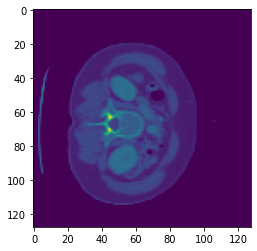

In [28]:
import matplotlib.pyplot as plt

sample_train = train_dataset[16]
plt.imshow(sample_train[0][2][PATCH_SIZE//2])

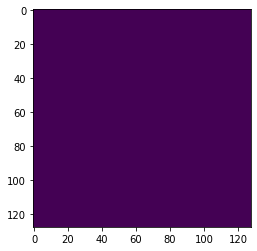

In [29]:
plt.imshow(sample_train[1][PATCH_SIZE//2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


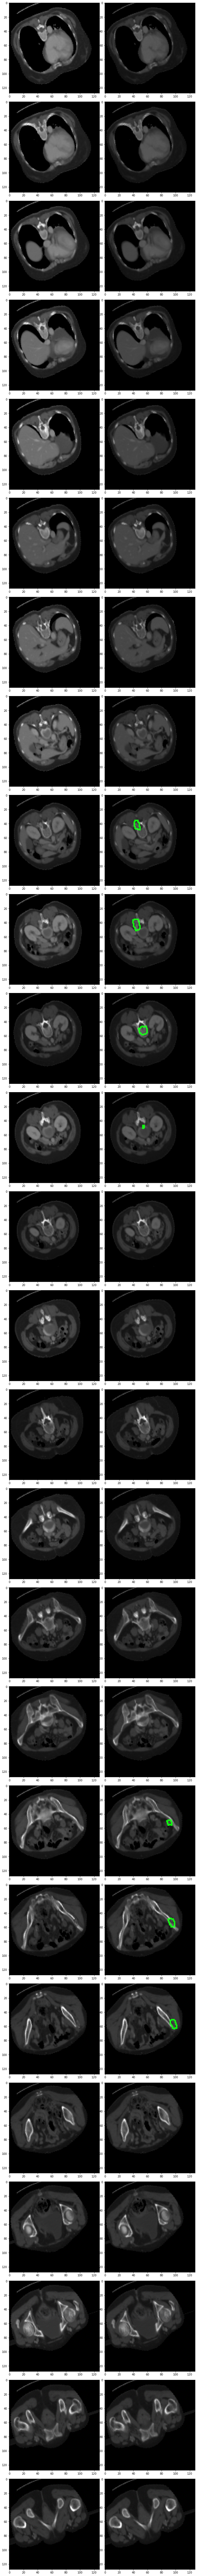

In [30]:
sample_train = train_dataset[16]
img = sample_train[0][2]
label = sample_train[1]

plot_img_and_label(img, label.type(torch.uint8))

# Dataloader 

In [31]:
import multiprocessing
multiprocessing.cpu_count()

48

In [32]:
from torch.utils.data import DataLoader

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
# NUM_WORKERS = multiprocessing.cpu_count()
NUM_WORKERS = 8

def initTrainDl(train_ds, batch_size = BATCH_SIZE):
    if USE_CUDA:
        batch_size *= torch.cuda.device_count()

    train_dl = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
        shuffle=True,
        drop_last=False # to prevent gradient exploding
    )
    return train_dl

def initValDl(val_ds, batch_size = BATCH_SIZE):
    val_dl = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=NUM_WORKERS,
        pin_memory=USE_CUDA,
    )
    return val_dl

# Set for training

In [33]:
import logging
log = logging.getLogger("3DUnet")
# log.setLevel(logging.WARN)
# log.setLevel(logging.INFO)
log.setLevel(logging.DEBUG)

In [34]:
import datetime
# For logging 
trn_writer = None
val_writer = None
# TB_PREFIX = img_type + "_fn0"
time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M.%S')

In [35]:
# Used for computeClassificationLoss and logMetrics to index into metrics_t/metrics_a
# METRICS_LABEL_NDX = 0
METRICS_LOSS_NDX = 1
# METRICS_FN_LOSS_NDX = 2
# METRICS_ALL_LOSS_NDX = 3

# METRICS_PTP_NDX = 4
# METRICS_PFN_NDX = 5
# METRICS_MFP_NDX = 6
METRICS_TP_NDX = 7
METRICS_FN_NDX = 8
METRICS_FP_NDX = 9

METRICS_SIZE = 10

In [36]:
from torch.optim import SGD, AdamW, RMSprop
from torch import nn
from pytorch3dunet.unet3d.model import UNet3D, ResidualUNet3D

def initModel():    
    segmentation_model = ResidualUNet3D(in_channels=3, out_channels=1, num_groups=32, f_maps=32, final_sigmoid=True, testing=True, num_levels=5)

    # augmentation_model = SegmentationAugmentation(**self.augmentation_dict)

    if USE_CUDA:
        log.info("Using CUDA; {} devices.".format(torch.cuda.device_count()))
        if torch.cuda.device_count() > 1:
            segmentation_model = nn.DataParallel(segmentation_model)
            # augmentation_model = nn.DataParallel(augmentation_model)
        segmentation_model = segmentation_model.to(DEVICE)
        # augmentation_model = augmentation_model.to(DEVICE)

    return segmentation_model #, augmentation_model

def initOptimizer():
    return AdamW(segmentation_model.parameters(), lr=0.0001, weight_decay=0.00001)
    # return SGD(segmentation_model.parameters(), lr=0.001, momentum=0.99)

segmentation_model = initModel()
optimizer = initOptimizer()

# Load model
if MODEL_TO_LOAD :
  model_folder = os.path.join(BASE_DIR, 'models')
  model_path = os.path.join(model_folder, MODEL_TO_LOAD)
  seg_dict = torch.load(model_path, map_location='cpu')
  if torch.cuda.device_count() > 1:
    segmentation_model.module.load_state_dict(seg_dict['model_state'])
  else:
    segmentation_model.load_state_dict(seg_dict['model_state'])
    

In [37]:
segmentation_model

DataParallel(
  (module): ResidualUNet3D(
    (encoders): ModuleList(
      (0): Encoder(
        (basic_module): ExtResNetBlock(
          (conv1): SingleConv(
            (groupnorm): GroupNorm(1, 3, eps=1e-05, affine=True)
            (conv): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (conv2): SingleConv(
            (groupnorm): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (conv3): SingleConv(
            (groupnorm): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
          (non_linearity): ReLU(inplace=True)
        )
      )
      (1): Encoder(
        (pooling): MaxPool3d(kernel_size=2, stride=2, paddin

In [38]:
# for name, param in segmentation_model.named_parameters():
#     print(name)

In [39]:
# ## 끝에만 학습하게 하고 나머지 변수는 얼려버리기
# for name, param in segmentation_model.named_parameters():
#     if ('module.encoders.4' in name) or ('module.encoders.5' in name) or ('module.decoders.0' in name):
#         continue;
#     param.requires_grad = False
#     print(name)


In [40]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(segmentation_model)

35317415

In [41]:
from util.util import enumerateWithEstimate

def doTraining(epoch_ndx, train_dl):
    trnMetrics_g = torch.zeros(METRICS_SIZE, len(train_dl.dataset), device=DEVICE)
    segmentation_model.train()
    # train_dl.dataset.shuffleSamples() - 정의에서 처리했음

    batch_iter = enumerateWithEstimate(
        train_dl,
        "E{} Training".format(epoch_ndx),
        start_ndx=train_dl.num_workers,
    )
    for batch_ndx, batch_tup in batch_iter:
        optimizer.zero_grad()

        loss_var = computeBatchLoss(batch_ndx, batch_tup, train_dl.batch_size, trnMetrics_g)
        loss_var.backward()
        
        # Gradient clipping 
        max_norm = 5
        torch.nn.utils.clip_grad_norm_(segmentation_model.parameters(), max_norm)
        optimizer.step()
    global totalTrainingSamples_count
    totalTrainingSamples_count += trnMetrics_g.size(1)

    return trnMetrics_g.to('cpu')

def doValidation(epoch_ndx, val_dl):
    with torch.no_grad():
        valMetrics_g = torch.zeros(METRICS_SIZE, len(val_dl.dataset), device=DEVICE)
        segmentation_model.eval()

        batch_iter = enumerateWithEstimate(
            val_dl,
            "E{} Validation ".format(epoch_ndx),
            start_ndx=val_dl.num_workers,
        )
        for batch_ndx, batch_tup in batch_iter:
            computeBatchLoss(batch_ndx, batch_tup, val_dl.batch_size, valMetrics_g)

    return valMetrics_g.to('cpu')

def computeBatchLoss(batch_ndx, batch_tup, batch_size, metrics_g,
                      classificationThreshold=0.5):
    input_t, label_t= batch_tup
    
    input_g = input_t.to(DEVICE, non_blocking=True)
    label_g = label_t.to(DEVICE, non_blocking=True)

    # if segmentation_model.training and augmentation_dict:
    #     input_g, label_g = augmentation_model(input_g, label_g)

    prediction_g_multi_ch = segmentation_model(input_g)
    prediction_g = prediction_g_multi_ch[:,0] # B, C, D, H, W -> B, D, H, W
    diceLoss_g = diceLoss(prediction_g, label_g)
    fnLoss_g = diceLoss(prediction_g * label_g, label_g)
    start_ndx = batch_ndx * batch_size
    end_ndx = start_ndx + input_t.size(0)

    with torch.no_grad():
        predictionBool_g = (prediction_g > classificationThreshold).to(torch.float32)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])

        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = diceLoss_g
        metrics_g[METRICS_TP_NDX, start_ndx:end_ndx] = tp
        metrics_g[METRICS_FN_NDX, start_ndx:end_ndx] = fn
        metrics_g[METRICS_FP_NDX, start_ndx:end_ndx] = fp

    return diceLoss_g.mean() + fnLoss_g.mean() * FN_LOSS

def diceLoss(prediction_g, label_g, epsilon=1):
    diceLabel_g = label_g.sum(dim=[1,2,3])
    dicePrediction_g = prediction_g.sum(dim=[1,2,3])
    diceCorrect_g = (prediction_g * label_g).sum(dim=[1,2,3])

    diceRatio_g = (2 * diceCorrect_g + epsilon) \
        / (dicePrediction_g + diceLabel_g + epsilon)

    return 1 - diceRatio_g

In [42]:
from torch.utils.tensorboard import SummaryWriter

def logMetrics(epoch_ndx, mode_str, metrics_t, tb_type = TB_PREFIX):
    log.info("E{} {} {}".format(
        epoch_ndx,
        "Unet",
        tb_type
    ))

    metrics_a = metrics_t.detach().numpy()
    sum_a = metrics_a.sum(axis=1)
    assert np.isfinite(metrics_a).all()

    allLabel_count = sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]

    metrics_dict = {}
    metrics_dict['loss/all'] = metrics_a[METRICS_LOSS_NDX].mean()

    metrics_dict['percent_all/tp'] = \
        sum_a[METRICS_TP_NDX] / (allLabel_count or 1) * 100 
    metrics_dict['percent_all/fn'] = \
        sum_a[METRICS_FN_NDX] / (allLabel_count or 1) * 100
    metrics_dict['percent_all/fp'] = \
        sum_a[METRICS_FP_NDX] / (allLabel_count or 1) * 100


    precision = metrics_dict['pr/precision'] = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FP_NDX]) or 1)
    recall    = metrics_dict['pr/recall']    = sum_a[METRICS_TP_NDX] \
        / ((sum_a[METRICS_TP_NDX] + sum_a[METRICS_FN_NDX]) or 1)

    metrics_dict['pr/f1_score'] = 2 * (precision * recall) \
        / ((precision + recall) or 1)

    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{pr/precision:.4f} precision, "
              + "{pr/recall:.4f} recall, "
              + "{pr/f1_score:.4f} f1 score"
              ).format(
        epoch_ndx,
        mode_str,
        **metrics_dict,
    ))
    log.info(("E{} {:8} "
              + "{loss/all:.4f} loss, "
              + "{percent_all/tp:-5.1f}% tp, {percent_all/fn:-5.1f}% fn, {percent_all/fp:-9.1f}% fp"
    ).format(
        epoch_ndx,
        mode_str + '_all',
        **metrics_dict,
    ))
    global trn_writer
    global val_writer
    initTensorboardWriters()
    if mode_str == 'trn':
      writer = trn_writer
    elif mode_str == 'pred':
      writer = pred_writer
    else:
      writer = val_writer

    prefix_str = 'seg_'

    global totalTrainingSamples_count
    for key, value in metrics_dict.items():
        writer.add_scalar(prefix_str + key, value, totalTrainingSamples_count)

    writer.flush()

    score = metrics_dict['pr/recall']

    return score

import os

LOG_DIR = os.path.join(BASE_DIR, 'logs')
if not os.path.exists(LOG_DIR):
  os.mkdir(LOG_DIR)
  
def initTensorboardWriters():
    global trn_writer
    global val_writer
    global pred_writer
    if trn_writer is None:
        trn_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_trn_seg_{}').format(TB_PREFIX, time_str) )
        val_writer = SummaryWriter(
            log_dir= os.path.join(LOG_DIR, '{}_val_seg_{}').format(TB_PREFIX, time_str) )
#         pred_writer = SummaryWriter(
#             log_dir= os.path.join(LOG_DIR, '{}_pred_seg_{}').format(TB_PREFIX, time_str) )

In [43]:
def saveModel(type_str, epoch_ndx, tb_pre = TB_PREFIX):
    model_name = '{}_model_epoch{}'.format(tb_pre, epoch_ndx)
    file_path = os.path.join(
        BASE_DIR,
        'models',
        model_name
        )

    os.makedirs(os.path.dirname(file_path), mode=0o755, exist_ok=True)

    model = segmentation_model
    if isinstance(model, torch.nn.DataParallel):
        model = model.module

    state = {
        'sys_argv': sys.argv,
        'time': str(datetime.datetime.now()),
        'model_state': model.state_dict(),
        'model_name': type(model).__name__,
        'optimizer_state' : optimizer.state_dict(),
        'optimizer_name': type(optimizer).__name__,
        'epoch': epoch_ndx,
        'totalTrainingSamples_count': totalTrainingSamples_count,
    }
    torch.save(state, file_path)
    log.info(f"Model was saved to {file_path}")
#     remote_location = 's3://{0}'.format(os.path.join(s3bucket, 'result/models', model_name))
#     S3FS.put(file_path, remote_location)
#     log.info("Saved model params to {} and remote S3 bucket".format(file_path))

    with open(file_path, 'rb') as f:
        log.info("SHA1: " + hashlib.sha1(f.read()).hexdigest())

In [44]:
import torch.nn.functional as F

# Pytorch 3D image tensor = Depth, Height, Weight
#w(l-> r), h(t->b), d(u->d) 순서로군
    
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

def convert_to_multi_channel_img(image, windows):
    adjusted_images = [adjust_window(image, window) for window in windows]
    return torch.stack(adjusted_images)

# Process : padding -> adjust windows -> unfold -> neural network -> fold -> crop
#           another padding -> adjust windows -> unfold -> neural network -> fold -> crop 
#           average all by 2 -> compare with the label. 
# 원래는 8개로 해야되는데, 간이 버전이라고 생각해볼 수 있겠음. 

def pred_image_with_model(padded_image, model, batch_size, patch_size):
    '''
    padded_image : image tensor with size of [D, H, W]
    patch_size : tuple with size of 3
    return pred_label : tensor with size of [D, H, W]
    '''
    windows = [(500,200), (700,400), (1200,400)]
    input_channel = padded_image.size(0)
    output_channel = 1
    patch_d, patch_h, patch_w = patch_size 
    total_batch_size = batch_size * torch.cuda.device_count()

    patches = padded_image.unfold(0, patch_d, patch_d).unfold(1, patch_h, patch_h).unfold(2, patch_w, patch_w)
    unfold_shape = patches.size()
    patches = patches.reshape(-1, patch_d, patch_h, patch_w)
    
    processed_patches = torch.zeros_like(patches)
    iter_num = int(np.ceil(patches.size(0)/total_batch_size))
    for i in range(iter_num):
        start = i * total_batch_size
        end = (i+1) * total_batch_size
        batch = patches[start:end]
        batch = convert_to_multi_channel_img(batch, windows)
        batch = batch.permute(1,0,2,3,4)
        proccessed_batch = model(batch).squeeze(1)
        processed_patches[start:end] = proccessed_batch
    
    pred_patches = processed_patches.view(unfold_shape)
    output_d = unfold_shape[0] * unfold_shape[3]
    output_h = unfold_shape[1] * unfold_shape[4]
    output_w = unfold_shape[2] * unfold_shape[5]
    pred_patches = pred_patches.permute(0, 3, 1, 4, 2, 5)
    pred_label = pred_patches.reshape(output_d, output_h, output_w)
    return pred_label

def predict_one_case(image_t, batch_size ,patch_size):
    pad_image = pad_for_division(image_t, patch_size)
    half_pad_image = pad_for_half(pad_image, patch_size)
    d,h,w = image_t.shape
    half_pad_d, half_pad_h, half_pad_w = [size//2 for size in patch_size]
    
    with torch.no_grad():
        segmentation_model.eval()
        pred_label = pred_image_with_model(pad_image, segmentation_model, batch_size, patch_size)
        pred_half_pad_label = pred_image_with_model(half_pad_image, segmentation_model, batch_size, patch_size)
        
    cropped_pred = pred_label[:d, :h, :w]
    cropped_pred_2 = pred_half_pad_label[half_pad_d:half_pad_d+d, half_pad_h:half_pad_h+h, half_pad_w:half_pad_w+w]
    mean_pred = (cropped_pred + cropped_pred_2) / 2
    return mean_pred


def doPrediction(epoch_ndx, files, batch_size, patch_size):
    log.info("E{} Prediction {}".format(epoch_ndx, TB_PREFIX))
    predMetrics_g = torch.zeros(METRICS_SIZE, len(files), device=DEVICE)
    segmentation_model.eval()
    
    for i, file in enumerate(files):
        image = np.load(get_img_path(file))
        image_t = torch.tensor(image)
        label = np.load(get_label_path(file))
        
        pred = predict_one_case(image_t, batch_size, patch_size)
        pred_t = pred > 0.5 # classificationThreshold = 0.5
        label_t = torch.tensor(label)
        
        predictionBool_g = pred_t.unsqueeze(0).to(torch.float32)
        label_g = label_t.unsqueeze(0)
        
        diceLoss_g = diceLoss(predictionBool_g, label_g, epsilon=0.01)
        fnLoss_g = diceLoss(predictionBool_g * label_g, label_g)

        tp = (     predictionBool_g *  label_g).sum(dim=[1,2,3])
        fn = ((1 - predictionBool_g) *  label_g).sum(dim=[1,2,3])
        fp = (     predictionBool_g * (~label_g)).sum(dim=[1,2,3])
        
        predMetrics_g[METRICS_LOSS_NDX, i] = diceLoss_g # 차원 에러날듯 - i로 골라버리면 차원이 하나 줄기 때문.. 확인해봐야함. 
        predMetrics_g[METRICS_TP_NDX, i] = tp
        predMetrics_g[METRICS_FN_NDX, i] = fn
        predMetrics_g[METRICS_FP_NDX, i] = fp
        
    return predMetrics_g.to('cpu')

# Train

In [45]:
log.info("Starting traning...")

train_dl = initTrainDl(train_dataset)
val_dl = initValDl(val_dataset)

best_score = 0.0
validation_cadence = 5
pred_cadence = 20

totalTrainingSamples_count = 0 

2022-01-19 19:41:54,120 INFO     pid:363593 3DUnet:001:<module> Starting traning...


In [ ]:
for epoch_ndx in range(101, 301):
    log.info("Epoch {} of {}, {}/{} batches of size {}*{}".format(
        epoch_ndx,
        EPOCHS,
        len(train_dl),
        len(val_dl),
        BATCH_SIZE,
        (torch.cuda.device_count() if USE_CUDA else 1),
    ))

    trnMetrics_t = doTraining(epoch_ndx, train_dl)

    logMetrics(epoch_ndx, 'trn', trnMetrics_t)

    if epoch_ndx == 1 or epoch_ndx % validation_cadence == 0:
        # if validation is wanted
        valMetrics_t = doValidation(epoch_ndx, val_dl)
        score = logMetrics(epoch_ndx, 'val', valMetrics_t)
        best_score = max(score, best_score)

        # self.saveModel('seg', epoch_ndx, score == best_score)
        saveModel('seg', epoch_ndx)
        # self.logImages(epoch_ndx, 'trn', train_dl)
        # self.logImages(epoch_ndx, 'val', val_dl)

#     if epoch_ndx % pred_cadence ==0:
#         predMetrics_t = doPrediction(epoch_ndx, VAL_FILES, batch_size=1, patch_size=(128,256,256))
#         score = logMetrics(epoch_ndx, 'pred', predMetrics_t)
        
trn_writer.close()
val_writer.close()

2022-01-19 22:44:23,119 INFO     pid:363593 3DUnet:008:<module> Epoch 101 of 100, 14/18 batches of size 4*4
2022-01-19 22:44:23,139 WARNING  pid:363593 util.util:221:enumerateWithEstimate E101 Training ----/14, starting
2022-01-19 22:45:43,791 WARNING  pid:363593 util.util:252:enumerateWithEstimate E101 Training ----/14, done at 2022-01-19 22:45:43
2022-01-19 22:45:43,795 INFO     pid:363593 3DUnet:007:logMetrics E101 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_Copy3
2022-01-19 22:45:43,797 INFO     pid:363593 3DUnet:043:logMetrics E101 trn      0.6461 loss, 0.5507 precision, 0.4177 recall, 0.4750 f1 score
2022-01-19 22:45:43,798 INFO     pid:363593 3DUnet:051:logMetrics E101 trn_all  0.6461 loss,  41.8% tp,  58.2% fn,      34.1% fp
2022-01-19 22:45:43,802 INFO     pid:363593 3DUnet:008:<module> Epoch 102 of 100, 14/18 batches of size 4*4
2022-01-19 22:45:43,805 WARNING  pid:363593 util.util:221:enumerateWithEstimate E102 Training ----/14, starting
2022-01-19 22:47:00,631 WARNI

2022-01-19 22:58:35,127 INFO     pid:363593 3DUnet:007:logMetrics E110 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_Copy3
2022-01-19 22:58:35,129 INFO     pid:363593 3DUnet:043:logMetrics E110 trn      0.6301 loss, 0.5681 precision, 0.4482 recall, 0.5011 f1 score
2022-01-19 22:58:35,131 INFO     pid:363593 3DUnet:051:logMetrics E110 trn_all  0.6301 loss,  44.8% tp,  55.2% fn,      34.1% fp
2022-01-19 22:58:35,137 WARNING  pid:363593 util.util:221:enumerateWithEstimate E110 Validation  ----/18, starting
2022-01-19 22:59:00,792 INFO     pid:363593 util.util:241:enumerateWithEstimate E110 Validation    16/18, done at 2022-01-19 22:59:02, 0:00:12
2022-01-19 22:59:01,051 WARNING  pid:363593 util.util:252:enumerateWithEstimate E110 Validation  ----/18, done at 2022-01-19 22:59:01
2022-01-19 22:59:01,154 INFO     pid:363593 3DUnet:007:logMetrics E110 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_Copy3
2022-01-19 22:59:01,155 INFO     pid:363593 3DUnet:043:logMetrics E110 val     

2022-01-19 23:10:11,685 INFO     pid:363593 3DUnet:043:logMetrics E118 trn      0.6254 loss, 0.5674 precision, 0.4095 recall, 0.4757 f1 score
2022-01-19 23:10:11,686 INFO     pid:363593 3DUnet:051:logMetrics E118 trn_all  0.6254 loss,  40.9% tp,  59.1% fn,      31.2% fp
2022-01-19 23:10:11,691 INFO     pid:363593 3DUnet:008:<module> Epoch 119 of 100, 14/18 batches of size 4*4
2022-01-19 23:10:11,694 WARNING  pid:363593 util.util:221:enumerateWithEstimate E119 Training ----/14, starting
2022-01-19 23:11:36,827 WARNING  pid:363593 util.util:252:enumerateWithEstimate E119 Training ----/14, done at 2022-01-19 23:11:36
2022-01-19 23:11:36,831 INFO     pid:363593 3DUnet:007:logMetrics E119 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_Copy3
2022-01-19 23:11:36,833 INFO     pid:363593 3DUnet:043:logMetrics E119 trn      0.6376 loss, 0.5579 precision, 0.4550 recall, 0.5012 f1 score
2022-01-19 23:11:36,834 INFO     pid:363593 3DUnet:051:logMetrics E119 trn_all  0.6376 loss,  45.5% tp,  54

2022-01-19 23:22:04,741 INFO     pid:363593 3DUnet:051:logMetrics E126 trn_all  0.6211 loss,  46.9% tp,  53.1% fn,      33.4% fp
2022-01-19 23:22:04,745 INFO     pid:363593 3DUnet:008:<module> Epoch 127 of 100, 14/18 batches of size 4*4
2022-01-19 23:22:04,748 WARNING  pid:363593 util.util:221:enumerateWithEstimate E127 Training ----/14, starting
2022-01-19 23:23:36,122 WARNING  pid:363593 util.util:252:enumerateWithEstimate E127 Training ----/14, done at 2022-01-19 23:23:36
2022-01-19 23:23:36,125 INFO     pid:363593 3DUnet:007:logMetrics E127 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_Copy3
2022-01-19 23:23:36,127 INFO     pid:363593 3DUnet:043:logMetrics E127 trn      0.6191 loss, 0.6101 precision, 0.4341 recall, 0.5073 f1 score
2022-01-19 23:23:36,129 INFO     pid:363593 3DUnet:051:logMetrics E127 trn_all  0.6191 loss,  43.4% tp,  56.6% fn,      27.7% fp
2022-01-19 23:23:36,133 INFO     pid:363593 3DUnet:008:<module> Epoch 128 of 100, 14/18 batches of size 4*4
2022-01-19 2

2022-01-19 23:35:33,537 WARNING  pid:363593 util.util:252:enumerateWithEstimate E135 Validation  ----/18, done at 2022-01-19 23:35:33
2022-01-19 23:35:33,647 INFO     pid:363593 3DUnet:007:logMetrics E135 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_Copy3
2022-01-19 23:35:33,648 INFO     pid:363593 3DUnet:043:logMetrics E135 val      0.7690 loss, 0.1766 precision, 0.2792 recall, 0.2164 f1 score
2022-01-19 23:35:33,649 INFO     pid:363593 3DUnet:051:logMetrics E135 val_all  0.7690 loss,  27.9% tp,  72.1% fn,     130.2% fp
2022-01-19 23:35:34,463 INFO     pid:363593 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_128/models/bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_Copy3_model_epoch135
2022-01-19 23:35:35,190 INFO     pid:363593 3DUnet:032:saveModel SHA1: c6655610128ea35f7639e4c29dc341827664878b
2022-01-19 23:35:35,191 INFO     pid:363593 3DUnet:008:<module> Epoch 136 of 100, 14/18 batches of size 4*4
2022-01-19 23:35:35,194 WARNING  pid:363593 util.util:221:e

2022-01-19 23:48:44,987 INFO     pid:363593 3DUnet:007:logMetrics E144 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_Copy3
2022-01-19 23:48:44,989 INFO     pid:363593 3DUnet:043:logMetrics E144 trn      0.6113 loss, 0.6078 precision, 0.4919 recall, 0.5438 f1 score
2022-01-19 23:48:44,990 INFO     pid:363593 3DUnet:051:logMetrics E144 trn_all  0.6113 loss,  49.2% tp,  50.8% fn,      31.7% fp
2022-01-19 23:48:44,994 INFO     pid:363593 3DUnet:008:<module> Epoch 145 of 100, 14/18 batches of size 4*4
2022-01-19 23:48:44,998 WARNING  pid:363593 util.util:221:enumerateWithEstimate E145 Training ----/14, starting
2022-01-19 23:50:09,736 WARNING  pid:363593 util.util:252:enumerateWithEstimate E145 Training ----/14, done at 2022-01-19 23:50:09
2022-01-19 23:50:09,740 INFO     pid:363593 3DUnet:007:logMetrics E145 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_Copy3
2022-01-19 23:50:09,742 INFO     pid:363593 3DUnet:043:logMetrics E145 trn      0.6205 loss, 0.6226 precision, 0.4581 re

2022-01-20 00:00:56,720 INFO     pid:363593 3DUnet:043:logMetrics E152 trn      0.6212 loss, 0.5974 precision, 0.4334 recall, 0.5024 f1 score
2022-01-20 00:00:56,721 INFO     pid:363593 3DUnet:051:logMetrics E152 trn_all  0.6212 loss,  43.3% tp,  56.7% fn,      29.2% fp
2022-01-20 00:00:56,727 INFO     pid:363593 3DUnet:008:<module> Epoch 153 of 100, 14/18 batches of size 4*4
2022-01-20 00:00:56,731 WARNING  pid:363593 util.util:221:enumerateWithEstimate E153 Training ----/14, starting
2022-01-20 00:02:18,481 WARNING  pid:363593 util.util:252:enumerateWithEstimate E153 Training ----/14, done at 2022-01-20 00:02:18
2022-01-20 00:02:18,484 INFO     pid:363593 3DUnet:007:logMetrics E153 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_Copy3
2022-01-20 00:02:18,486 INFO     pid:363593 3DUnet:043:logMetrics E153 trn      0.5995 loss, 0.5393 precision, 0.4782 recall, 0.5069 f1 score
2022-01-20 00:02:18,488 INFO     pid:363593 3DUnet:051:logMetrics E153 trn_all  0.5995 loss,  47.8% tp,  52

2022-01-20 00:12:37,856 INFO     pid:363593 3DUnet:032:saveModel SHA1: 6da0503c791fb32eb60e838dca3fe5c1fc3280f7
2022-01-20 00:12:37,857 INFO     pid:363593 3DUnet:008:<module> Epoch 161 of 100, 14/18 batches of size 4*4
2022-01-20 00:12:37,859 WARNING  pid:363593 util.util:221:enumerateWithEstimate E161 Training ----/14, starting
2022-01-20 00:14:01,484 WARNING  pid:363593 util.util:252:enumerateWithEstimate E161 Training ----/14, done at 2022-01-20 00:14:01
2022-01-20 00:14:01,488 INFO     pid:363593 3DUnet:007:logMetrics E161 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_Copy3
2022-01-20 00:14:01,490 INFO     pid:363593 3DUnet:043:logMetrics E161 trn      0.5948 loss, 0.6339 precision, 0.4890 recall, 0.5521 f1 score
2022-01-20 00:14:01,491 INFO     pid:363593 3DUnet:051:logMetrics E161 trn_all  0.5948 loss,  48.9% tp,  51.1% fn,      28.2% fp
2022-01-20 00:14:01,496 INFO     pid:363593 3DUnet:008:<module> Epoch 162 of 100, 14/18 batches of size 4*4
2022-01-20 00:14:01,499 WARNI

2022-01-20 00:27:18,661 INFO     pid:363593 3DUnet:007:logMetrics E170 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_Copy3
2022-01-20 00:27:18,663 INFO     pid:363593 3DUnet:043:logMetrics E170 trn      0.5888 loss, 0.6231 precision, 0.4839 recall, 0.5447 f1 score
2022-01-20 00:27:18,663 INFO     pid:363593 3DUnet:051:logMetrics E170 trn_all  0.5888 loss,  48.4% tp,  51.6% fn,      29.3% fp
2022-01-20 00:27:18,669 WARNING  pid:363593 util.util:221:enumerateWithEstimate E170 Validation  ----/18, starting
2022-01-20 00:27:45,957 INFO     pid:363593 util.util:241:enumerateWithEstimate E170 Validation    16/18, done at 2022-01-20 00:27:47, 0:00:14
2022-01-20 00:27:46,203 WARNING  pid:363593 util.util:252:enumerateWithEstimate E170 Validation  ----/18, done at 2022-01-20 00:27:46
2022-01-20 00:27:46,319 INFO     pid:363593 3DUnet:007:logMetrics E170 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_Copy3
2022-01-20 00:27:46,320 INFO     pid:363593 3DUnet:043:logMetrics E170 val     

2022-01-20 00:39:20,628 INFO     pid:363593 3DUnet:043:logMetrics E178 trn      0.5844 loss, 0.6382 precision, 0.5019 recall, 0.5619 f1 score
2022-01-20 00:39:20,629 INFO     pid:363593 3DUnet:051:logMetrics E178 trn_all  0.5844 loss,  50.2% tp,  49.8% fn,      28.4% fp
2022-01-20 00:39:20,633 INFO     pid:363593 3DUnet:008:<module> Epoch 179 of 100, 14/18 batches of size 4*4
2022-01-20 00:39:20,636 WARNING  pid:363593 util.util:221:enumerateWithEstimate E179 Training ----/14, starting
2022-01-20 00:40:48,181 WARNING  pid:363593 util.util:252:enumerateWithEstimate E179 Training ----/14, done at 2022-01-20 00:40:48
2022-01-20 00:40:48,185 INFO     pid:363593 3DUnet:007:logMetrics E179 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_Copy3
2022-01-20 00:40:48,187 INFO     pid:363593 3DUnet:043:logMetrics E179 trn      0.5812 loss, 0.6349 precision, 0.4957 recall, 0.5568 f1 score
2022-01-20 00:40:48,188 INFO     pid:363593 3DUnet:051:logMetrics E179 trn_all  0.5812 loss,  49.6% tp,  50

2022-01-20 00:51:15,090 INFO     pid:363593 3DUnet:051:logMetrics E186 trn_all  0.5727 loss,  54.1% tp,  45.9% fn,      34.1% fp
2022-01-20 00:51:15,096 INFO     pid:363593 3DUnet:008:<module> Epoch 187 of 100, 14/18 batches of size 4*4
2022-01-20 00:51:15,100 WARNING  pid:363593 util.util:221:enumerateWithEstimate E187 Training ----/14, starting
2022-01-20 00:52:35,061 WARNING  pid:363593 util.util:252:enumerateWithEstimate E187 Training ----/14, done at 2022-01-20 00:52:35
2022-01-20 00:52:35,063 INFO     pid:363593 3DUnet:007:logMetrics E187 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_Copy3
2022-01-20 00:52:35,064 INFO     pid:363593 3DUnet:043:logMetrics E187 trn      0.5739 loss, 0.6311 precision, 0.5104 recall, 0.5644 f1 score
2022-01-20 00:52:35,065 INFO     pid:363593 3DUnet:051:logMetrics E187 trn_all  0.5739 loss,  51.0% tp,  49.0% fn,      29.8% fp
2022-01-20 00:52:35,067 INFO     pid:363593 3DUnet:008:<module> Epoch 188 of 100, 14/18 batches of size 4*4
2022-01-20 0

2022-01-20 01:04:10,761 WARNING  pid:363593 util.util:252:enumerateWithEstimate E195 Validation  ----/18, done at 2022-01-20 01:04:10
2022-01-20 01:04:10,866 INFO     pid:363593 3DUnet:007:logMetrics E195 Unet bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_Copy3
2022-01-20 01:04:10,867 INFO     pid:363593 3DUnet:043:logMetrics E195 val      0.7263 loss, 0.3018 precision, 0.2954 recall, 0.2986 f1 score
2022-01-20 01:04:10,868 INFO     pid:363593 3DUnet:051:logMetrics E195 val_all  0.7263 loss,  29.5% tp,  70.5% fn,      68.3% fp
2022-01-20 01:04:11,690 INFO     pid:363593 3DUnet:026:saveModel Model was saved to /workspace/BoneMeta_all_128/models/bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_Copy3_model_epoch195
2022-01-20 01:04:12,440 INFO     pid:363593 3DUnet:032:saveModel SHA1: c13a9aefde514d7460068d48d4e8fd675aaaace2
2022-01-20 01:04:12,441 INFO     pid:363593 3DUnet:008:<module> Epoch 196 of 100, 14/18 batches of size 4*4
2022-01-20 01:04:12,443 WARNING  pid:363593 util.util:221:e

In [47]:
!ls $BASE_DIR/logs

bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_Copy3_trn_seg_2022-01-19_19.41.49
bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_Copy3_val_seg_2022-01-19_19.41.49
bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_trn_seg_2022-01-19_17.26.52
bonemeta_fn_0_3D_Unet_Res_lv5_All128_LyticOnly_NoCopy_val_seg_2022-01-19_17.26.52
bonemeta_fn_0_3D_Unet_Res_lv6_PS128_All128_pred_seg_2021-10-24_18.56.32
bonemeta_fn_0_3D_Unet_Res_lv6_PS128_All128_pred_seg_2021-10-24_23.31.14
bonemeta_fn_0_3D_Unet_Res_lv6_PS128_All128_trn_seg_2021-10-24_18.56.32
bonemeta_fn_0_3D_Unet_Res_lv6_PS128_All128_trn_seg_2021-10-24_23.31.14
bonemeta_fn_0_3D_Unet_Res_lv6_PS128_All128_val_seg_2021-10-24_18.56.32
bonemeta_fn_0_3D_Unet_Res_lv6_PS128_All128_val_seg_2021-10-24_23.31.14


In [48]:
# !rm -r $BASE_DIR/logs

In [49]:
%debug

2022-01-19 22:11:34,814 ERROR    pid:363593 root:1188:debugger No traceback has been produced, nothing to debug.
